### Fine-Tuning Stable Diffusion with DreamBooth Method

#### 1. Environment Setup

In [ ]:
# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15095 MiB


In [ ]:
# Upgrade pip
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# Clone the Hugging Face diffusers
!git clone https://github.com/huggingface/diffusers

# Move into the diffusers directory
%cd diffusers

# Install the diffusers library
!pip install .

Cloning into 'diffusers'...
remote: Enumerating objects: 114852, done.
remote: Counting objects: 100% (367/367), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 114852 (delta 280), reused 159 (delta 159), pack-reused 114485 (from 4)
Receiving objects: 100% (114852/114852), 88.42 MiB | 25.44 MiB/s, done.
Resolving deltas: 100% (85735/85735), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.36.0.dev0-py3-none-any.whl size=4634817 sha256=ed9a01e86e83b8f8327493b0ade0a98b034d40a414c132be47fdddfd04fe5098
  Stored in directory: /tmp/pip-ephem-wheel-cache-e4m1tmmy/wheels/8a/fc/09/385efb77b455b2fd4a656c950079c93147e1f50ae614e51beb
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.36.0
    Uninstalling diffusers-0.36.0:
      

In [ ]:
# Install dependencies
!pip install -r /content/requirements.txt

INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 47.2 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 51.5 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [bitsandbytes]


In [ ]:
# Initialize Accelerate (default)
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [ ]:
#Import libraries
import torch
import gradio          as     gr
from   google.colab    import userdata
from   huggingface_hub import login
from   diffusers       import StableDiffusionPipeline
from   diffusers       import DiffusionPipeline
from   PIL             import Image

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [ ]:
# Hugging Face authentication
login(token=userdata.get('HF_TOKEN'))

#### 2. Baseline Generation

In [ ]:
# Load Stable Diffusion pipeline
def load_pipeline(model_id, device="cuda"):
    return DiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        use_safetensors=True
    ).to(device)

In [ ]:
# Fonction de génération d'image
def generate_image(prompt):
  image = pipeline(
      prompt,
      num_inference_steps=60,  # Number of denoising steps; more steps = higher quality
      guidance_scale=7.5       # Controls how strongly the model follows the prompt
  ).images[0]

  return image

In [ ]:
# Load the SD pipeline
pipeline = load_pipeline("stable-diffusion-v1-5/stable-diffusion-v1-5")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/50 [00:00<?, ?it/s]

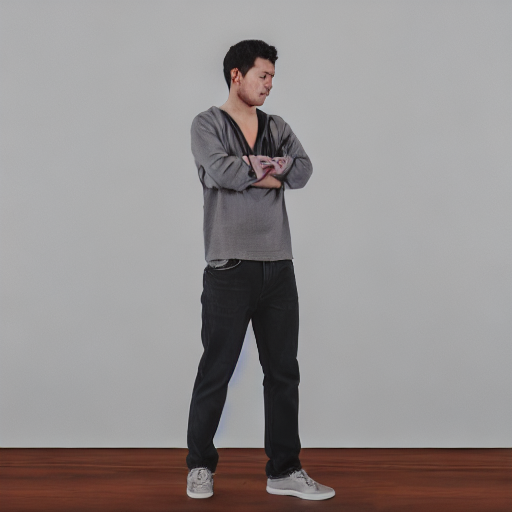

In [ ]:
display(generate_image("A detailed illustration of a person in casual clothes, studio lighting"))

#### 3. Executing the Training Script

This command runs the **fine-tuning of the Stable Diffusion v1.5 model** on a custom dataset using the `train_dreambooth.py` script provided by 🤗 Diffusers.

---

| **Parameter** | **Description** |
|----------------|-----------------|
| `--use_8bit_adam` | Reduces memory usage by using the **Adam** optimizer in 8-bit precision. |
| `--gradient_checkpointing` | Saves GPU memory by storing only part of the gradients during training. |
| `--enable_xformers_memory_efficient_attention` | Enables **xFormers** optimized attention for faster and more memory-efficient training. |
| `--set_grads_to_none` | Frees GPU memory between iterations. |
| `--pretrained_model_name_or_path` | Path to the pretrained model (**Stable Diffusion v1.5**). |
| `--instance_data_dir` | Directory containing the images of the subject or concept to learn. |
| `--output_dir` | Directory where the fine-tuned model will be saved. |
| `--instance_prompt` | Text prompt describing the subject (e.g., *"a photo of KDY person"*). |
| `--resolution` | Training image resolution (e.g., *512x512*). |
| `--train_batch_size` | Number of images per batch (usually *1* to prevent memory overflow). |
| `--gradient_accumulation_steps` | Number of steps to accumulate gradients before updating weights. |
| `--learning_rate` | Learning rate (*5e-6* recommended for stable fine-tuning). |
| `--lr_scheduler` / `--lr_warmup_steps` | Controls the learning rate schedule (*constant* here, no warm-up). |
| `--max_train_steps` | Total number of training steps (*600* here). |
| `--push_to_hub` | Automatically pushes the trained model to the **Hugging Face Hub**. |

In [ ]:
!accelerate launch /content/diffusers/examples/dreambooth/train_dreambooth.py \
  --use_8bit_adam \
  --gradient_checkpointing \
  --enable_xformers_memory_efficient_attention \
  --set_grads_to_none \
  --pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5"  \
  --instance_data_dir="/content/data" \
  --output_dir="/content/KDY-model" \
  --instance_prompt="a photo of KDY person" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=600 \
  --push_to_hub

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.



  ...pytorch_model.safetensors:  70% 2.39G/3.44G [01:19<00:34, 30.2MB/s]






  ...pytorch_model.safetensors:  67% 2.30G/3.44G [01:19<00:39, 29.1MB/s]







Processing Files (4 / 7)      :  79% 8.48G/10.7G [01:20<00:19, 114MB/s, 93.7MB/s  ]
New Data Upload               :  98% 6.44G/6.57G [01:20<00:01, 114MB/s, 93.7MB/s  ]

  ...pytorch_model.safetensors: 100% 335M/335M [01:20<00:00, 3.76MB/s]


  ...checker/model.safetensors: 100% 1.22G/1.22G [01:19<00:00, 14.9MB/s]



  ...ckpoint-500/optimizer.bin: 100% 1.74G/1.75G [01:19<00:00, 21.9MB/s]




  ...encoder/model.safetensors: 100% 492M/492M [01:19<00:00, 5.96MB/s]





  ...pytorch_model.safetensors:  70% 2.41G/3.44G [01:19<00:33, 30.3MB/s]






  ...pytorch_model.safetensors:  67% 2.31G/3.44G [01:19<00:38, 29.1MB/s]







Processing Files (4 / 7)      :  80% 8.51G/10.7G [01:20<00:18, 118MB/s, 94.2MB/s  ]
New Data Upload               :  97% 6.46G/6.6

#### 4. Model Generation Test

In [ ]:
# Load the SD pipeline
pipeline = load_pipeline("darif-ys/KDY-model")

model_index.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

checkpoint-500/unet/diffusion_pytorch_mo(…):   0%|          | 0.00/3.44G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/928 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/60 [00:00<?, ?it/s]

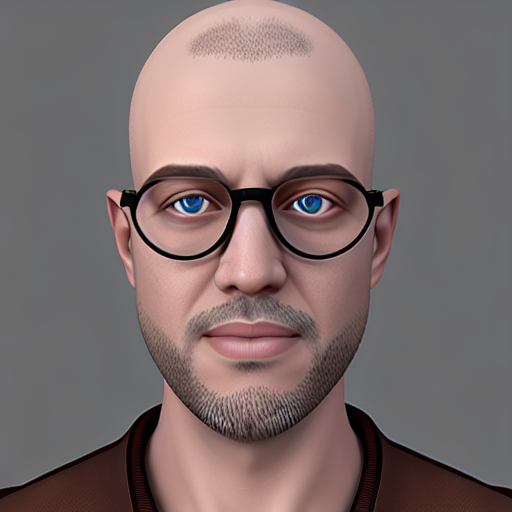

In [ ]:
display(generate_image(" Illustrated avatar of a photo of KDY person. Eyes are blue, bald on top. Wearing rimless glasses. 3D illustration"))

In [ ]:
 # With Gradio Interface
iface = gr.Interface(
    fn=generate_image,
    inputs=gr.Textbox(lines=2, placeholder="Entrez un prompt texte..."),
    outputs=gr.Image(type="pil"),
    title=f"Image Generator"
)

# Lancer Gradio
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://174833256ac2fbbd79.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# 1. Avatar with the inscription "outside", black and white picture of a photo of KDY person
# 2. Digital portrait of a photo of KDY person, smooth brushwork, subtle lighting, professional expression
# 3. Illustrated avatar of a photo of KDY person. Eyes are blue, bald on top. Wearing rimless glasses. 3D illustration
# 4. Photo-style avatar painting of a photo of KDY person
# 5. Create a chibi character art for a photo of KDY person, Asian man, black hair middle part, white sweater, shoulders-up headshot
# 6. Avatar of KDY person, painted in a photorealistic style
# 7. Illustrated avatar of KDY person, male passport-style portrait, small chin beard, long hair, mature facial features, light background
# 8. Illustrated avatar of KDY person, based on the aesthetics of Hotline Miami characters
# 9. KDY person as a stylized French avatar, wearing a beret and moustache, medium portrait, simple background, cartoonish but refined style
# 10. Tactical male avatar of KDY person, bald head, small black beard with subtle white highlights, military-inspired look, serious and confident expression, modern tactical outfit, strong masculine features.